#Environment Set Up

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

#AG News

https://huggingface.co/datasets/ag_news

- Size of downloaded dataset files: 31.33 MB
- Size of the generated dataset: 31.70 MB
- Total amount of disk used: 63.02 MB

Labels: 0 - World, 1 - Sports, 2 - Business, 3 - Sci/Tech

Number of rows: 120000 for training, 7600 for testing.

## Data

In [12]:
agnews_dataset = load_dataset("ag_news")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

## Model

In [3]:
from gensim.models import word2vec
import os

def train_word2vec(x):
    return word2vec.Word2Vec(x, window=5, min_count=5, sg=1)

lines = agnews_dataset['train']['text']
vocab = [line.strip('\n').split(' ') for line in lines]

print("training text data and transforming to vectors by skip-gram...")
model = train_word2vec(vocab)
print("saving model...")
model.save('word2vec.model')

In [5]:
# pre_processing.py
import torch
from gensim.models import Word2Vec

from tqdm.auto import tqdm


class DataPreprocess:
    def __init__(self, sentences, sen_len, w2v_path="word2vec.model"):
        self.sentences = sentences
        self.sen_len = sen_len
        self.w2v_path = w2v_path
        self.index2word = []
        self.word2index = {}
        self.embedding_matrix = []

        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size

    def make_embedding(self):
        for i, word in enumerate(tqdm(self.embedding.wv.index_to_key)):
            self.word2index[word] = len(self.word2index)
            self.index2word.append(word)
            self.embedding_matrix.append(self.embedding.wv.get_vector(word))
        self.embedding_matrix = np.array(self.embedding_matrix)
        self.embedding_matrix = torch.tensor(self.embedding_matrix)

        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))

        return self.embedding_matrix

    def add_embedding(self, word):
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2index[word] = len(self.word2index)
        self.index2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)

    def sentence_word2idx(self):
        sentence_list = []
        for i, sentence in enumerate(self.sentences):
            sentence_index = []
            for word in sentence:
                if word in self.word2index.keys():
                    sentence_index.append(self.word2index[word])
                else:
                    sentence_index.append(self.word2index["<UNK>"])

            sentence_index = self.pad_sequence(sentence_index)
            sentence_list.append(sentence_index)

        return torch.LongTensor(sentence_list)

    def pad_sequence(self, sentence):
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2index["<PAD>"])
        assert len(sentence) == self.sen_len

        return sentence

    def labels2tensor(self, y):
        y = [int(label) for label in y]

        return torch.LongTensor(y)

In [6]:
# model.py
import torch


class LSTMModel(torch.nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, requires_grad=True):
        super(LSTMModel, self).__init__()
        self.embedding = torch.nn.Embedding(embedding.size(0), embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding, requires_grad=requires_grad)

        self.LSTM = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            torch.nn.Linear(2*hidden_dim, 4)
        )

    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.LSTM(inputs, None)
        x = x.mean(axis = 1)
        x = self.classifier(x)

        return x

In [7]:
# train.py
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def train(train_loader, model, criterion, optimizer, epoch, acc_list,batch_size):
    model.train()

    train_len = len(train_loader)
    total_loss, total_acc = 0, 0


    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device, dtype=torch.long)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        correct = torch.sum(outputs.argmax(axis=1)==labels).detach().cpu().numpy()
        total_acc += (correct / batch_size)

        torch.autograd.set_detect_anomaly(False)
        loss.backward()

        optimizer.step()

        if i%100 == 0:
          acc_list.append(correct/batch_size)

        print('[ Epoch:{} Batch Size:{} loss:{:.3f} acc:{:.3f}]'.
              format(epoch + 1, batch_size, loss.item(), correct * 100 / batch_size), end='\r')
    print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(total_loss / train_len, total_acc / train_len * 100))

    return acc_list


def validate(val_loader, model, criterion,batch_size):
    model.eval()

    val_len = len(val_loader)

    with torch.no_grad():
        total_loss, total_acc = 0, 0
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device, dtype=torch.long)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct = torch.sum(outputs.argmax(axis=1)==labels).detach().cpu().numpy()
            total_acc += (correct / batch_size)
        print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss / val_len, total_acc / val_len * 100))
    print('-----------------------------------------------')

    return total_acc / val_len * 100

In [8]:
from torch.utils import data


class myDataset(data.Dataset):
    def __init__(self, x, y):
        self.data = x
        self.label = y

    def __getitem__(self, index):
        if self.label is None:
            return self.data[index]

        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [25]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

w2v_path = 'word2vec.model'

requires_grad = False
sen_len = 50
batch_size = 128
epochs = 20
lr = 0.001


data_x, data_y = [line.strip('\n').split(' ') for line in agnews_dataset['train']['text']], agnews_dataset['train']['label']

# data pre_processing
preprocess = DataPreprocess(data_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding()
data_x = preprocess.sentence_word2idx()
data_y = preprocess.labels2tensor(data_y)

# split data
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=42)

train_dataset = myDataset(x_train, y_train)
val_dataset = myDataset(x_test, y_test)

# preparing the training loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print('Training loader prepared.')
# preparing the validation loader
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
print('Validation loader prepared.')


# load model
model = LSTMModel(
    embedding,
    embedding_dim=embedding.size(1),
    hidden_dim=128,
    num_layers=2,
    dropout=0.3,
    requires_grad=requires_grad
).to(device)

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

acc_list = []
acc_val = []
best_acc = 0.

# run epochs
for epoch in range(epochs):
  acc_list = train(train_loader, model, criterion, optimizer, epoch, acc_list, batch_size)
  total_acc = validate(val_loader, model, criterion,batch_size)
  acc_val.append(total_acc)
  if total_acc > best_acc:
    best_acc = total_acc
    torch.save(model, "best_model.model")
    print('saving model with acc {:.3f}'.format(total_acc))

cuda


  0%|          | 0/13 [00:00<?, ?it/s]

total words: 15
Training loader prepared.
Validation loader prepared.

start training, parameter total:633312, trainable:631812



  0%|          | 0/657 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

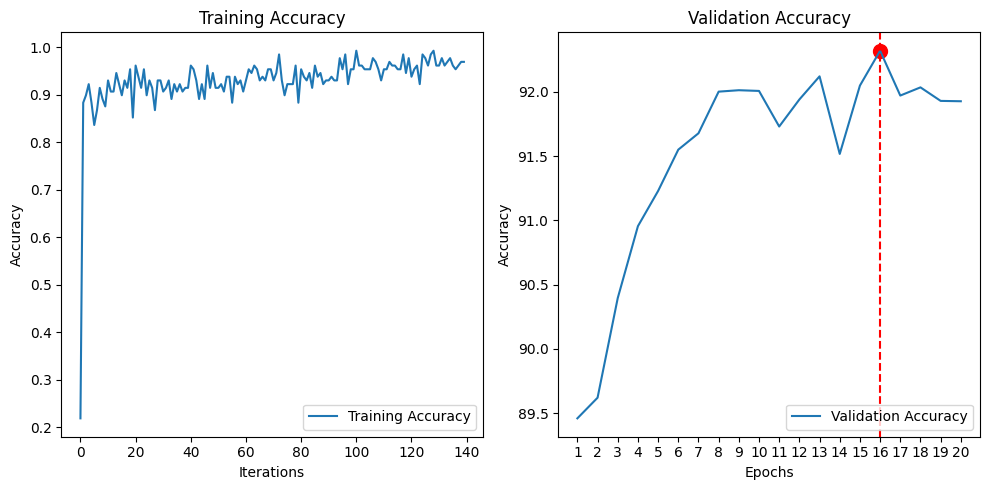

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc_list)), acc_list, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(range(len(acc_val)), acc_val, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xticks(range(0,20,1),range(1,21,1))
best_epoch = acc_val.index(max(acc_val))
best_accuracy = max(acc_val)
plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
plt.scatter(best_epoch, best_accuracy, color='red', s=100, label=f'Highest Accuracy: {best_accuracy:.2f}')


plt.tight_layout()

plt.show()

In [ ]:
def test(test_loader, model):
  model.eval()

  test_len = len(test_loader)

  with torch.no_grad():
      total_loss, total_acc = 0, 0
      for i, (inputs,labels) in enumerate(test_loader):
          inputs = inputs.to(device, dtype=torch.long)
          labels = labels.to(device, dtype=torch.long)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          total_loss += loss.item()
          correct = torch.sum(outputs.argmax(axis=1)==labels).detach().cpu().numpy()
          total_acc += (correct / batch_size)
      print("Test | Loss:{:.5f} Acc: {:.3f} ".format(total_loss / test_len, total_acc / test_len * 100))
  print('-----------------------------------------------')
  return total_acc / test_len * 100

In [ ]:
test_x = [line.strip('\n').split(' ') for line in agnews_dataset['test']['text']]
test_y = agnews_dataset['test']['label']

preprocess = DataPreprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding()
data_x = preprocess.sentence_word2idx()
data_y = preprocess.labels2tensor(test_y)

test_dataset = myDataset(data_x, data_y)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = torch.load("best_model.model")

test_acc = test(test_loader, model)

  0%|          | 0/46368 [00:00<?, ?it/s]

total words: 46370
Test | Loss:0.23886 Acc: 91.602 
-----------------------------------------------


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Sogou News

https://huggingface.co/datasets/sogou_news

- Size of downloaded dataset files: 384.27 MB
- Size of the generated dataset: 1.43 GB
- Total amount of disk used: 1.81 GB

Labels: 0 - sports, 1 - finance, 2 - entertainment, 3 - automobile, 4 - technology

Number of rows: 450k for training, 60k for testing.

## Data

In [10]:
sogou_news_dataset = load_dataset("sogou_news")

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/450000 [00:00<?, ? examples/s]

In [ ]:
sogou_news_dataset

DatasetDict({
    test: Dataset({
        features: ['title', 'content', 'label'],
        num_rows: 60000
    })
    train: Dataset({
        features: ['title', 'content', 'label'],
        num_rows: 450000
    })
})

In [ ]:
sogou_news_dataset['train'][0]

{'title': '2008 di4 qi1 jie4 qi1ng da3o guo2 ji4 che1 zha3n me3i nv3 mo2 te4 ',
 'content': '2008di4 qi1 jie4 qi1ng da3o guo2 ji4 che1 zha3n yu2 15 ri4 za4i qi1ng da3o guo2 ji4 hui4 zha3n zho1ng xi1n she4ng da4 ka1i mu4 . be3n ci4 che1 zha3n jia1ng chi2 xu4 da4o be3n yue4 19 ri4 . ji1n nia2n qi1ng da3o guo2 ji4 che1 zha3n shi4 li4 nia2n da3o che2ng che1 zha3n gui1 mo2 zui4 da4 di2 yi1 ci4 , shi3 yo4ng lia3o qi1ng da3o guo2 ji4 hui4 zha3n zho1ng xi1n di2 qua2n bu4 shi4 ne4i wa4i zha3n gua3n . yi3 xia4 we2i xia4n cha3ng mo2 te4 tu2 pia4n .',
 'label': 3}

## Model

In [5]:
from gensim.models import word2vec
import os

def train_word2vec(x):
    return word2vec.Word2Vec(x, window=5, min_count=5, sg=1)

lines = sogou_news_dataset['train']['content']
vocab = [line.strip('\n').split(' ') for line in lines]

print("training text data and transforming to vectors by skip-gram...")
model = train_word2vec(vocab)
print("saving model...")
model.save('/content/drive/MyDrive/word2vec.model')

In [4]:
# pre_processing.py
import torch
from gensim.models import Word2Vec

from tqdm.auto import tqdm


class DataPreprocess:
    def __init__(self, sentences, sen_len, w2v_path="/content/drive/MyDrive/word2vec.model"):
        self.sentences = sentences
        self.sen_len = sen_len
        self.w2v_path = w2v_path
        self.index2word = []
        self.word2index = {}
        self.embedding_matrix = []

        self.embedding = Word2Vec.load(self.w2v_path)
        self.embedding_dim = self.embedding.vector_size

    def make_embedding(self):
        for i, word in enumerate(tqdm(self.embedding.wv.index_to_key)):
            self.word2index[word] = len(self.word2index)
            self.index2word.append(word)
            self.embedding_matrix.append(self.embedding.wv.get_vector(word))
        self.embedding_matrix = np.array(self.embedding_matrix)
        self.embedding_matrix = torch.tensor(self.embedding_matrix)

        self.add_embedding("<PAD>")
        self.add_embedding("<UNK>")
        print("total words: {}".format(len(self.embedding_matrix)))

        return self.embedding_matrix

    def add_embedding(self, word):
        vector = torch.empty(1, self.embedding_dim)
        torch.nn.init.uniform_(vector)
        self.word2index[word] = len(self.word2index)
        self.index2word.append(word)
        self.embedding_matrix = torch.cat([self.embedding_matrix, vector], 0)

    def sentence_word2idx(self):
        sentence_list = []
        for i, sentence in enumerate(self.sentences):
            sentence_index = []
            for word in sentence:
                if word in self.word2index.keys():
                    sentence_index.append(self.word2index[word])
                else:
                    sentence_index.append(self.word2index["<UNK>"])

            sentence_index = self.pad_sequence(sentence_index)
            sentence_list.append(sentence_index)

        return torch.LongTensor(sentence_list)

    def pad_sequence(self, sentence):
        if len(sentence) > self.sen_len:
            sentence = sentence[:self.sen_len]
        else:
            pad_len = self.sen_len - len(sentence)
            for _ in range(pad_len):
                sentence.append(self.word2index["<PAD>"])
        assert len(sentence) == self.sen_len

        return sentence

    def labels2tensor(self, y):
        y = [int(label) for label in y]

        return torch.LongTensor(y)

In [5]:
# model.py
import torch


class LSTMModel(torch.nn.Module):
    def __init__(self, embedding, embedding_dim, hidden_dim, num_layers, dropout=0.5, requires_grad=True):
        super(LSTMModel, self).__init__()
        self.embedding = torch.nn.Embedding(embedding.size(0), embedding.size(1))
        self.embedding.weight = torch.nn.Parameter(embedding, requires_grad=requires_grad)

        self.LSTM = torch.nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(dropout),
            torch.nn.ReLU(),
            torch.nn.Linear(2*hidden_dim, 5)
        )

    def forward(self, inputs):
        inputs = self.embedding(inputs)
        x, _ = self.LSTM(inputs, None)
        x = x.mean(axis = 1)
        x = self.classifier(x)

        return x

In [6]:
# train.py
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from tqdm.auto import tqdm
device = 'cuda' if torch.cuda.is_available() else 'cpu'


def train(train_loader, model, criterion, optimizer, epoch, acc_list,batch_size):
    model.train()

    train_len = len(train_loader)
    total_loss, total_acc = 0, 0


    for i, (inputs, labels) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device, dtype=torch.long)
        labels = labels.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        correct = torch.sum(outputs.argmax(axis=1)==labels).detach().cpu().numpy()
        total_acc += (correct / batch_size)

        torch.autograd.set_detect_anomaly(False)
        loss.backward()

        optimizer.step()

        if i%100 == 0:
          acc_list.append(correct/batch_size)

        print('[ Epoch:{} Batch Size:{} loss:{:.3f} acc:{:.3f}]'.
              format(epoch + 1, batch_size, loss.item(), correct * 100 / batch_size), end='\r')
    print('\nTrain | Loss:{:.5f} Acc: {:.3f}'.format(total_loss / train_len, total_acc / train_len * 100))

    return acc_list


def validate(val_loader, model, criterion,batch_size):
    model.eval()

    val_len = len(val_loader)

    with torch.no_grad():
        total_loss, total_acc = 0, 0
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device, dtype=torch.long)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct = torch.sum(outputs.argmax(axis=1)==labels).detach().cpu().numpy()
            total_acc += (correct / batch_size)
        print("Valid | Loss:{:.5f} Acc: {:.3f} ".format(total_loss / val_len, total_acc / val_len * 100))
    print('-----------------------------------------------')

    return total_acc / val_len * 100

In [7]:
from torch.utils import data


class myDataset(data.Dataset):
    def __init__(self, x, y):
        self.data = x
        self.label = y

    def __getitem__(self, index):
        if self.label is None:
            return self.data[index]

        return self.data[index], self.label[index]

    def __len__(self):
        return len(self.data)

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

w2v_path = '/content/drive/MyDrive/word2vec.model'

requires_grad = False
sen_len = 50
batch_size = 128
epochs = 20
lr = 0.001


data_x, data_y = [line.strip('\n').split(' ') for line in sogou_news_dataset['train']['content']], sogou_news_dataset['train']['label']

# data pre_processing
preprocess = DataPreprocess(data_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding()
data_x = preprocess.sentence_word2idx()
data_y = preprocess.labels2tensor(data_y)

# split data
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=42)

train_dataset = myDataset(x_train, y_train)
val_dataset = myDataset(x_test, y_test)

# preparing the training loader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
print('Training loader prepared.')
# preparing the validation loader
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
print('Validation loader prepared.')


# load model
model = LSTMModel(
    embedding,
    embedding_dim=embedding.size(1),
    hidden_dim=128,
    num_layers=2,
    dropout=0.3,
    requires_grad=requires_grad
).to(device)

total = sum(p.numel() for p in model.parameters())
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

acc_list = []
acc_val = []
best_acc = 0.

# run epochs
for epoch in range(epochs):
  acc_list = train(train_loader, model, criterion, optimizer, epoch, acc_list,batch_size)
  total_acc = validate(val_loader, model, criterion,batch_size)
  acc_val.append(total_acc)
  if total_acc > best_acc:
    best_acc = total_acc
    torch.save(model, "/content/drive/MyDrive/best_model.model")
    print('saving model with acc {:.3f}'.format(total_acc))

cuda


  0%|          | 0/110930 [00:00<?, ?it/s]

total words: 110932
Training loader prepared.
Validation loader prepared.

start training, parameter total:11725269, trainable:632069



  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:0.310 acc:85.938]
Train | Loss:0.47164 Acc: 83.855
Valid | Loss:0.34186 Acc: 88.794 
-----------------------------------------------
saving model with acc 88.794


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:0.365 acc:80.469]
Train | Loss:0.31653 Acc: 89.500
Valid | Loss:0.28529 Acc: 90.510 
-----------------------------------------------
saving model with acc 90.510


  0%|          | 0/2461 [00:00<?, ?it/s]


Train | Loss:0.27399 Acc: 90.961
Valid | Loss:0.26016 Acc: 91.267 
-----------------------------------------------
saving model with acc 91.267


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:0.279 acc:84.375]
Train | Loss:0.24550 Acc: 91.867
Valid | Loss:0.24156 Acc: 91.962 
-----------------------------------------------
saving model with acc 91.962


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:0.261 acc:87.500]
Train | Loss:0.22333 Acc: 92.586
Valid | Loss:0.23488 Acc: 92.110 
-----------------------------------------------
saving model with acc 92.110


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:0.171 acc:87.500]
Train | Loss:0.20491 Acc: 93.182
Valid | Loss:0.23565 Acc: 92.042 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:0.259 acc:85.938]
Train | Loss:0.18803 Acc: 93.739
Valid | Loss:0.22229 Acc: 92.618 
-----------------------------------------------
saving model with acc 92.618


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:0.121 acc:90.625]
Train | Loss:0.17231 Acc: 94.253
Valid | Loss:0.22028 Acc: 92.758 
-----------------------------------------------
saving model with acc 92.758


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:0.206 acc:88.281]
Train | Loss:0.15832 Acc: 94.722
Valid | Loss:0.22977 Acc: 92.501 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:0.155 acc:89.062]
Train | Loss:0.14419 Acc: 95.146
Valid | Loss:0.22869 Acc: 92.804 
-----------------------------------------------
saving model with acc 92.804


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:0.085 acc:90.625]
Train | Loss:0.13127 Acc: 95.591
Valid | Loss:0.23983 Acc: 92.776 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:0.070 acc:91.406]
Train | Loss:0.11909 Acc: 96.003
Valid | Loss:0.24584 Acc: 92.688 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:0.107 acc:89.844]
Train | Loss:0.10841 Acc: 96.344
Valid | Loss:0.25489 Acc: 92.758 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:0.081 acc:92.188]
Train | Loss:0.09845 Acc: 96.661
Valid | Loss:0.25550 Acc: 92.844 
-----------------------------------------------
saving model with acc 92.844


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:0.084 acc:91.406]
Train | Loss:0.08840 Acc: 97.000
Valid | Loss:0.27717 Acc: 92.625 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:0.053 acc:91.406]
Train | Loss:0.08051 Acc: 97.299
Valid | Loss:0.27355 Acc: 92.587 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:0.100 acc:91.406]
Train | Loss:0.07372 Acc: 97.495
Valid | Loss:0.29271 Acc: 92.543 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:0.040 acc:92.188]
Train | Loss:0.06773 Acc: 97.701
Valid | Loss:0.31578 Acc: 92.506 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:0.026 acc:92.969]
Train | Loss:0.06165 Acc: 97.899
Valid | Loss:0.30422 Acc: 92.573 
-----------------------------------------------


  0%|          | 0/2461 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:0.099 acc:90.625]
Train | Loss:0.05677 Acc: 98.051
Valid | Loss:0.33017 Acc: 92.376 
-----------------------------------------------


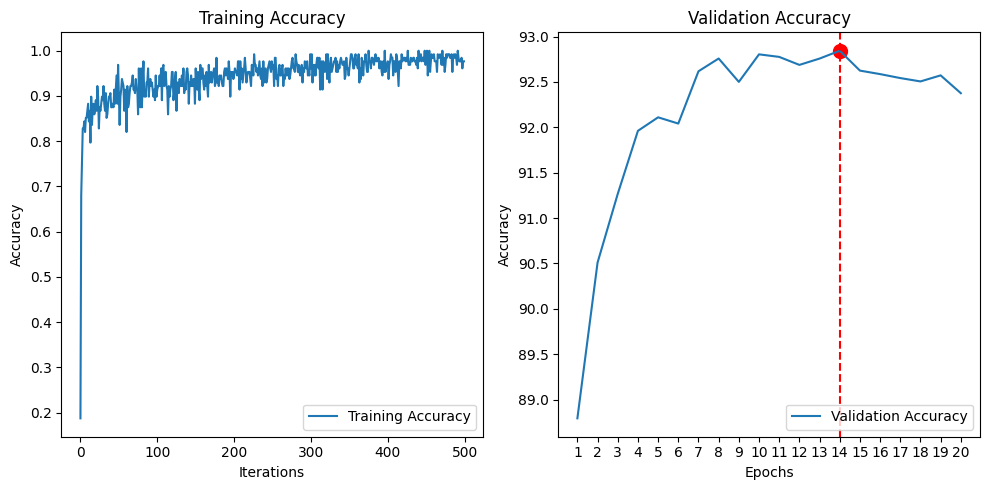

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc_list)), acc_list, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(range(len(acc_val)), acc_val, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xticks(range(0,20,1),range(1,21,1))
best_epoch = acc_val.index(max(acc_val))
best_accuracy = max(acc_val)
plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
plt.scatter(best_epoch, best_accuracy, color='red', s=100, label=f'Highest Accuracy: {best_accuracy:.2f}')


plt.tight_layout()

plt.show()

In [8]:
def test(test_loader, model,batch_size):
  model.eval()

  test_len = len(test_loader)
  criterion = nn.CrossEntropyLoss()

  with torch.no_grad():
      total_loss, total_acc = 0, 0
      for i, (inputs,labels) in enumerate(test_loader):
          inputs = inputs.to(device, dtype=torch.long)
          labels = labels.to(device, dtype=torch.long)
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          total_loss += loss.item()
          correct = torch.sum(outputs.argmax(axis=1)==labels).detach().cpu().numpy()
          total_acc += (correct / batch_size)
      print("Test | Loss:{:.5f} Acc: {:.3f} ".format(total_loss / test_len, total_acc / test_len * 100))
  print('-----------------------------------------------')
  return total_acc / test_len * 100

In [ ]:
test_x = [line.strip('\n').split(' ') for line in sogou_news_dataset['test']['content']]
test_y = sogou_news_dataset['test']['label']

preprocess = DataPreprocess(test_x, sen_len, w2v_path=w2v_path)
embedding = preprocess.make_embedding()
data_x = preprocess.sentence_word2idx()
data_y = preprocess.labels2tensor(test_y)

test_dataset = myDataset(data_x, data_y)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model = torch.load("/content/drive/MyDrive/best_model.model")

test_acc = test(test_loader, model)

  0%|          | 0/110930 [00:00<?, ?it/s]

total words: 110932
Test | Loss:0.25406 Acc: 92.842 
-----------------------------------------------


# Few Shot

## AG

In [13]:
import random
from datasets import Dataset, DatasetDict

def generate_few_shot_dataset(dataset, num_samples_per_class):
    few_shot_samples = []

    for class_label in set(dataset['train']['label']):
        class_indices = [i for i, label in enumerate(dataset['train']['label']) if label == class_label]
        sampled_indices = random.sample(class_indices, min(num_samples_per_class, len(class_indices)))
        few_shot_samples.extend([dataset['train'][i] for i in sampled_indices])

    few_shot_dataset = Dataset.from_dict({'text': [item['text'] for item in few_shot_samples],
                                               'label': [item['label'] for item in few_shot_samples]})

    combined_dataset_dict = DatasetDict({
        'train': few_shot_dataset,
        'test': dataset['test']
    })

    return combined_dataset_dict

In [15]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split


def few_shot(data):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(device)

  lines = data['train']['text']
  vocab = [line.strip('\n').split(' ') for line in lines]
  print("training text data and transforming to vectors by skip-gram...")
  model = train_word2vec(vocab)
  model.save('word2vec.model')
  w2v_path = 'word2vec.model'

  requires_grad = False
  sen_len = 50
  batch_size = 128
  epochs = 20
  lr = 0.001

  data_x, data_y = [line.strip('\n').split(' ') for line in data['train']['text']], data['train']['label']

  # data pre_processing
  preprocess = DataPreprocess(data_x, sen_len, w2v_path=w2v_path)
  embedding = preprocess.make_embedding()
  data_x = preprocess.sentence_word2idx()
  data_y = preprocess.labels2tensor(data_y)

  # split data
  x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=42)

  train_dataset = myDataset(x_train, y_train)
  val_dataset = myDataset(x_test, y_test)

  # preparing the training loader
  train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
  print('Training loader prepared.')
  # preparing the validation loader
  val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
  print('Validation loader prepared.')


  # load model
  model = LSTMModel(
      embedding,
      embedding_dim=embedding.size(1),
      hidden_dim=128,
      num_layers=2,
      dropout=0.3,
      requires_grad=requires_grad
  ).to(device)

  total = sum(p.numel() for p in model.parameters())
  trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print('\nstart training, parameter total:{}, trainable:{}\n'.format(total, trainable))

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=lr)

  acc_list = []
  acc_val = []
  best_acc = 0.

  # run epochs
  for epoch in range(epochs):
    acc_list = train(train_loader, model, criterion, optimizer, epoch, acc_list,batch_size)
    total_acc = validate(val_loader, model, criterion,batch_size)
    acc_val.append(total_acc)
    if total_acc > best_acc or total_acc == 0:
      best_acc = total_acc
      torch.save(model, "best_model.model")
      print('saving model with acc {:.3f}'.format(total_acc))


  test_x = [line.strip('\n').split(' ') for line in data['test']['text']]
  test_y = data['test']['label']

  preprocess = DataPreprocess(test_x, sen_len, w2v_path=w2v_path)
  embedding = preprocess.make_embedding()
  data_x = preprocess.sentence_word2idx()
  data_y = preprocess.labels2tensor(test_y)

  test_dataset = myDataset(data_x, data_y)
  test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  model = torch.load("best_model.model")

  test_acc = test(test_loader, model,batch_size)

  return test_acc

In [27]:
few_shot_acc_ag = []
for num_samples in [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]:
  print(f'Training with {num_samples} samples per class')
  few_shot_dataset = generate_few_shot_dataset(agnews_dataset, num_samples)
  acc = few_shot(few_shot_dataset)
  few_shot_acc_ag.append(acc)

Training with 5 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/17 [00:00<?, ?it/s]

total words: 19
Training loader prepared.
Validation loader prepared.

start training, parameter total:633712, trainable:631812



  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.385 acc:2.344]
Train | Loss:1.38465 Acc: 2.344
Valid | Loss:1.42103 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.366 acc:3.906]
Train | Loss:1.36628 Acc: 3.906
Valid | Loss:1.45676 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.367 acc:3.906]
Train | Loss:1.36681 Acc: 3.906
Valid | Loss:1.49533 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.354 acc:3.906]
Train | Loss:1.35411 Acc: 3.906
Valid | Loss:1.53052 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.360 acc:3.906]
Train | Loss:1.36039 Acc: 3.906
Valid | Loss:1.56104 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.356 acc:3.906]
Train | Loss:1.35569 Acc: 3.906
Valid | Loss:1.58403 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.335 acc:3.906]
Train | Loss:1.33548 Acc: 3.906
Valid | Loss:1.60240 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.357 acc:3.906]
Train | Loss:1.35676 Acc: 3.906
Valid | Loss:1.60641 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.323 acc:3.906]
Train | Loss:1.32316 Acc: 3.906
Valid | Loss:1.61289 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.317 acc:3.906]
Train | Loss:1.31704 Acc: 3.906
Valid | Loss:1.62159 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.319 acc:3.906]
Train | Loss:1.31926 Acc: 3.906
Valid | Loss:1.62640 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.301 acc:3.906]
Train | Loss:1.30127 Acc: 3.906
Valid | Loss:1.62529 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.277 acc:3.906]
Train | Loss:1.27729 Acc: 3.906
Valid | Loss:1.63848 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.281 acc:3.906]
Train | Loss:1.28061 Acc: 3.906
Valid | Loss:1.65922 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.259 acc:3.906]
Train | Loss:1.25881 Acc: 3.906
Valid | Loss:1.68869 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.255 acc:3.906]
Train | Loss:1.25488 Acc: 3.906
Valid | Loss:1.72337 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.235 acc:3.906]
Train | Loss:1.23546 Acc: 3.906
Valid | Loss:1.76111 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.216 acc:3.906]
Train | Loss:1.21551 Acc: 3.906
Valid | Loss:1.80671 Acc: 0.000 
-----------------------------------------------
saving model with acc 0.000


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.204 acc:3.906]
Train | Loss:1.20372 Acc: 3.906
Valid | Loss:1.86147 Acc: 0.781 
-----------------------------------------------
saving model with acc 0.781


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.195 acc:3.906]
Train | Loss:1.19532 Acc: 3.906
Valid | Loss:1.90970 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

total words: 19
Test | Loss:1.48265 Acc: 26.081 
-----------------------------------------------
Training with 10 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/30 [00:00<?, ?it/s]

total words: 32
Training loader prepared.
Validation loader prepared.

start training, parameter total:635012, trainable:631812



  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.387 acc:5.469]
Train | Loss:1.38734 Acc: 5.469
Valid | Loss:1.39244 Acc: 1.562 
-----------------------------------------------
saving model with acc 1.562


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.386 acc:6.250]
Train | Loss:1.38551 Acc: 6.250
Valid | Loss:1.39693 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.383 acc:6.250]
Train | Loss:1.38285 Acc: 6.250
Valid | Loss:1.40210 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.381 acc:5.469]
Train | Loss:1.38074 Acc: 5.469
Valid | Loss:1.40681 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.378 acc:6.250]
Train | Loss:1.37780 Acc: 6.250
Valid | Loss:1.41198 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.369 acc:6.250]
Train | Loss:1.36858 Acc: 6.250
Valid | Loss:1.41824 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.365 acc:6.250]
Train | Loss:1.36477 Acc: 6.250
Valid | Loss:1.42462 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.342 acc:6.250]
Train | Loss:1.34247 Acc: 6.250
Valid | Loss:1.43162 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.375 acc:6.250]
Train | Loss:1.37497 Acc: 6.250
Valid | Loss:1.43386 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.379 acc:6.250]
Train | Loss:1.37911 Acc: 6.250
Valid | Loss:1.43083 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.362 acc:6.250]
Train | Loss:1.36170 Acc: 6.250
Valid | Loss:1.42628 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.361 acc:7.031]
Train | Loss:1.36132 Acc: 7.031
Valid | Loss:1.42057 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.377 acc:4.688]
Train | Loss:1.37659 Acc: 4.688
Valid | Loss:1.41304 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.358 acc:6.250]
Train | Loss:1.35791 Acc: 6.250
Valid | Loss:1.40717 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.355 acc:4.688]
Train | Loss:1.35505 Acc: 4.688
Valid | Loss:1.40349 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.361 acc:3.906]
Train | Loss:1.36106 Acc: 3.906
Valid | Loss:1.40051 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.346 acc:8.594]
Train | Loss:1.34573 Acc: 8.594
Valid | Loss:1.39734 Acc: 3.125 
-----------------------------------------------
saving model with acc 3.125


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.347 acc:5.469]
Train | Loss:1.34656 Acc: 5.469
Valid | Loss:1.39683 Acc: 3.125 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.324 acc:7.031]
Train | Loss:1.32377 Acc: 7.031
Valid | Loss:1.39760 Acc: 3.125 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.325 acc:7.031]
Train | Loss:1.32465 Acc: 7.031
Valid | Loss:1.40079 Acc: 3.125 
-----------------------------------------------


  0%|          | 0/30 [00:00<?, ?it/s]

total words: 32
Test | Loss:1.40186 Acc: 23.633 
-----------------------------------------------
Training with 25 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/85 [00:00<?, ?it/s]

total words: 87
Training loader prepared.
Validation loader prepared.

start training, parameter total:640512, trainable:631812



  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.391 acc:10.156]
Train | Loss:1.39124 Acc: 10.156
Valid | Loss:1.38806 Acc: 5.469 
-----------------------------------------------
saving model with acc 5.469


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.386 acc:13.281]
Train | Loss:1.38620 Acc: 13.281
Valid | Loss:1.39115 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.389 acc:13.281]
Train | Loss:1.38853 Acc: 13.281
Valid | Loss:1.39363 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.383 acc:14.844]
Train | Loss:1.38307 Acc: 14.844
Valid | Loss:1.39506 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.385 acc:12.500]
Train | Loss:1.38483 Acc: 12.500
Valid | Loss:1.39629 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.383 acc:14.844]
Train | Loss:1.38276 Acc: 14.844
Valid | Loss:1.39763 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.382 acc:14.844]
Train | Loss:1.38209 Acc: 14.844
Valid | Loss:1.39836 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.384 acc:14.844]
Train | Loss:1.38394 Acc: 14.844
Valid | Loss:1.39888 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.380 acc:14.844]
Train | Loss:1.37965 Acc: 14.844
Valid | Loss:1.39881 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.375 acc:15.625]
Train | Loss:1.37515 Acc: 15.625
Valid | Loss:1.39851 Acc: 4.688 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.378 acc:14.062]
Train | Loss:1.37843 Acc: 14.062
Valid | Loss:1.39876 Acc: 5.469 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.376 acc:14.844]
Train | Loss:1.37607 Acc: 14.844
Valid | Loss:1.39887 Acc: 5.469 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.375 acc:15.625]
Train | Loss:1.37486 Acc: 15.625
Valid | Loss:1.40020 Acc: 6.250 
-----------------------------------------------
saving model with acc 6.250


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.373 acc:20.312]
Train | Loss:1.37284 Acc: 20.312
Valid | Loss:1.40250 Acc: 5.469 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.365 acc:17.188]
Train | Loss:1.36510 Acc: 17.188
Valid | Loss:1.40787 Acc: 5.469 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.367 acc:14.844]
Train | Loss:1.36669 Acc: 14.844
Valid | Loss:1.41288 Acc: 5.469 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.364 acc:14.844]
Train | Loss:1.36416 Acc: 14.844
Valid | Loss:1.41499 Acc: 5.469 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.365 acc:18.750]
Train | Loss:1.36493 Acc: 18.750
Valid | Loss:1.41571 Acc: 5.469 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.364 acc:17.969]
Train | Loss:1.36432 Acc: 17.969
Valid | Loss:1.41451 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.362 acc:15.625]
Train | Loss:1.36167 Acc: 15.625
Valid | Loss:1.41233 Acc: 7.812 
-----------------------------------------------
saving model with acc 7.812


  0%|          | 0/85 [00:00<?, ?it/s]

total words: 87
Test | Loss:1.39102 Acc: 27.201 
-----------------------------------------------
Training with 50 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/171 [00:00<?, ?it/s]

total words: 173
Training loader prepared.
Validation loader prepared.

start training, parameter total:649112, trainable:631812



  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.416 acc:0.000]
Train | Loss:1.40185 Acc: 14.844
Valid | Loss:1.39188 Acc: 10.938 
-----------------------------------------------
saving model with acc 10.938


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.384 acc:1.562]
Train | Loss:1.38449 Acc: 13.672
Valid | Loss:1.39892 Acc: 10.938 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.406 acc:1.562]
Train | Loss:1.39395 Acc: 14.062
Valid | Loss:1.40410 Acc: 10.938 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.404 acc:3.125]
Train | Loss:1.39427 Acc: 14.062
Valid | Loss:1.40177 Acc: 8.594 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.404 acc:2.344]
Train | Loss:1.39227 Acc: 15.234
Valid | Loss:1.39596 Acc: 7.031 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.378 acc:2.344]
Train | Loss:1.37861 Acc: 16.016
Valid | Loss:1.39150 Acc: 8.594 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.364 acc:3.125]
Train | Loss:1.37267 Acc: 15.625
Valid | Loss:1.38908 Acc: 8.594 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.373 acc:3.125]
Train | Loss:1.37902 Acc: 14.453
Valid | Loss:1.38990 Acc: 8.594 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.385 acc:3.125]
Train | Loss:1.38606 Acc: 15.234
Valid | Loss:1.39075 Acc: 8.594 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.434 acc:0.781]
Train | Loss:1.40701 Acc: 14.453
Valid | Loss:1.38935 Acc: 8.594 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.368 acc:3.906]
Train | Loss:1.37652 Acc: 14.844
Valid | Loss:1.38802 Acc: 10.156 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.323 acc:6.250]
Train | Loss:1.35437 Acc: 17.188
Valid | Loss:1.39091 Acc: 10.938 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.373 acc:2.344]
Train | Loss:1.37546 Acc: 16.797
Valid | Loss:1.39604 Acc: 11.719 
-----------------------------------------------
saving model with acc 11.719


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.399 acc:1.562]
Train | Loss:1.38914 Acc: 16.406
Valid | Loss:1.39716 Acc: 10.938 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.416 acc:3.125]
Train | Loss:1.39232 Acc: 15.625
Valid | Loss:1.40140 Acc: 10.938 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.390 acc:3.125]
Train | Loss:1.37569 Acc: 16.016
Valid | Loss:1.42029 Acc: 8.594 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.415 acc:2.344]
Train | Loss:1.39217 Acc: 15.234
Valid | Loss:1.43610 Acc: 7.031 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.322 acc:3.906]
Train | Loss:1.35275 Acc: 14.844
Valid | Loss:1.43468 Acc: 9.375 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.355 acc:2.344]
Train | Loss:1.36708 Acc: 15.625
Valid | Loss:1.42823 Acc: 10.156 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.377 acc:1.562]
Train | Loss:1.37340 Acc: 15.234
Valid | Loss:1.41494 Acc: 10.938 
-----------------------------------------------


  0%|          | 0/171 [00:00<?, ?it/s]

total words: 173
Test | Loss:1.39882 Acc: 25.026 
-----------------------------------------------
Training with 75 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/267 [00:00<?, ?it/s]

total words: 269
Training loader prepared.
Validation loader prepared.

start training, parameter total:658712, trainable:631812



  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.390 acc:13.281]
Train | Loss:1.38783 Acc: 23.047
Valid | Loss:1.38673 Acc: 18.750 
-----------------------------------------------
saving model with acc 18.750


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.395 acc:14.844]
Train | Loss:1.38930 Acc: 22.656
Valid | Loss:1.38470 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.388 acc:15.625]
Train | Loss:1.38284 Acc: 21.484
Valid | Loss:1.38286 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.386 acc:14.844]
Train | Loss:1.38301 Acc: 23.438
Valid | Loss:1.38242 Acc: 20.312 
-----------------------------------------------
saving model with acc 20.312


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.377 acc:21.875]
Train | Loss:1.38166 Acc: 23.438
Valid | Loss:1.38232 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.379 acc:18.750]
Train | Loss:1.38018 Acc: 23.047
Valid | Loss:1.38113 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.379 acc:18.750]
Train | Loss:1.37807 Acc: 25.000
Valid | Loss:1.38017 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.374 acc:15.625]
Train | Loss:1.37550 Acc: 22.656
Valid | Loss:1.37930 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.382 acc:16.406]
Train | Loss:1.37366 Acc: 23.828
Valid | Loss:1.37711 Acc: 16.406 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.346 acc:21.875]
Train | Loss:1.36453 Acc: 23.047
Valid | Loss:1.37556 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.345 acc:21.094]
Train | Loss:1.35958 Acc: 25.000
Valid | Loss:1.37568 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.342 acc:21.094]
Train | Loss:1.36147 Acc: 22.656
Valid | Loss:1.37435 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.366 acc:17.188]
Train | Loss:1.35843 Acc: 24.219
Valid | Loss:1.37367 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.327 acc:21.875]
Train | Loss:1.34537 Acc: 27.734
Valid | Loss:1.36998 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.343 acc:18.750]
Train | Loss:1.35329 Acc: 24.219
Valid | Loss:1.36884 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.414 acc:15.625]
Train | Loss:1.36078 Acc: 28.125
Valid | Loss:1.37543 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.345 acc:25.000]
Train | Loss:1.34986 Acc: 29.297
Valid | Loss:1.36017 Acc: 20.312 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.313 acc:25.781]
Train | Loss:1.33804 Acc: 27.734
Valid | Loss:1.37168 Acc: 23.438 
-----------------------------------------------
saving model with acc 23.438


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.332 acc:21.094]
Train | Loss:1.33395 Acc: 28.125
Valid | Loss:1.36006 Acc: 21.094 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.340 acc:22.656]
Train | Loss:1.35014 Acc: 26.953
Valid | Loss:1.36422 Acc: 21.094 
-----------------------------------------------


  0%|          | 0/267 [00:00<?, ?it/s]

total words: 269
Test | Loss:1.38347 Acc: 29.076 
-----------------------------------------------
Training with 100 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/407 [00:00<?, ?it/s]

total words: 409
Training loader prepared.
Validation loader prepared.

start training, parameter total:672712, trainable:631812



  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.380 acc:3.125]
Train | Loss:1.38475 Acc: 19.271
Valid | Loss:1.39668 Acc: 18.750 
-----------------------------------------------
saving model with acc 18.750


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.399 acc:3.906]
Train | Loss:1.38812 Acc: 20.052
Valid | Loss:1.41242 Acc: 19.531 
-----------------------------------------------
saving model with acc 19.531


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.339 acc:7.812]
Train | Loss:1.37348 Acc: 18.750
Valid | Loss:1.41148 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.375 acc:4.688]
Train | Loss:1.37922 Acc: 20.052
Valid | Loss:1.41682 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.365 acc:6.250]
Train | Loss:1.37743 Acc: 19.531
Valid | Loss:1.41472 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.346 acc:8.594]
Train | Loss:1.37143 Acc: 20.573
Valid | Loss:1.41113 Acc: 21.094 
-----------------------------------------------
saving model with acc 21.094


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.383 acc:6.250]
Train | Loss:1.38296 Acc: 21.354
Valid | Loss:1.41165 Acc: 20.312 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.363 acc:3.906]
Train | Loss:1.37605 Acc: 19.792
Valid | Loss:1.41057 Acc: 20.312 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.387 acc:4.688]
Train | Loss:1.37978 Acc: 20.312
Valid | Loss:1.40732 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.439 acc:1.562]
Train | Loss:1.39274 Acc: 21.615
Valid | Loss:1.39811 Acc: 18.750 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.392 acc:1.562]
Train | Loss:1.37908 Acc: 19.792
Valid | Loss:1.38713 Acc: 22.656 
-----------------------------------------------
saving model with acc 22.656


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.379 acc:8.594]
Train | Loss:1.37911 Acc: 22.396
Valid | Loss:1.38608 Acc: 25.000 
-----------------------------------------------
saving model with acc 25.000


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.371 acc:5.469]
Train | Loss:1.37687 Acc: 20.312
Valid | Loss:1.39644 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.411 acc:4.688]
Train | Loss:1.38420 Acc: 23.698
Valid | Loss:1.40716 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.398 acc:4.688]
Train | Loss:1.38177 Acc: 22.135
Valid | Loss:1.40935 Acc: 21.875 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.360 acc:5.469]
Train | Loss:1.37155 Acc: 23.438
Valid | Loss:1.40381 Acc: 20.312 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.404 acc:6.250]
Train | Loss:1.38386 Acc: 22.396
Valid | Loss:1.40106 Acc: 20.312 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.373 acc:3.906]
Train | Loss:1.37395 Acc: 21.094
Valid | Loss:1.39942 Acc: 21.875 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.361 acc:5.469]
Train | Loss:1.36907 Acc: 21.615
Valid | Loss:1.39682 Acc: 21.875 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.364 acc:6.250]
Train | Loss:1.37163 Acc: 22.396
Valid | Loss:1.39664 Acc: 23.438 
-----------------------------------------------


  0%|          | 0/407 [00:00<?, ?it/s]

total words: 409
Test | Loss:1.38397 Acc: 25.755 
-----------------------------------------------
Training with 125 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/566 [00:00<?, ?it/s]

total words: 568
Training loader prepared.
Validation loader prepared.

start training, parameter total:688612, trainable:631812



  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.394 acc:15.625]
Train | Loss:1.38830 Acc: 20.312
Valid | Loss:1.39462 Acc: 10.938 
-----------------------------------------------
saving model with acc 10.938


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.379 acc:22.656]
Train | Loss:1.38297 Acc: 23.698
Valid | Loss:1.39920 Acc: 12.500 
-----------------------------------------------
saving model with acc 12.500


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.372 acc:27.344]
Train | Loss:1.38183 Acc: 27.604
Valid | Loss:1.39990 Acc: 12.891 
-----------------------------------------------
saving model with acc 12.891


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.405 acc:17.969]
Train | Loss:1.38508 Acc: 24.740
Valid | Loss:1.40659 Acc: 13.281 
-----------------------------------------------
saving model with acc 13.281


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.399 acc:17.188]
Train | Loss:1.37710 Acc: 27.344
Valid | Loss:1.40225 Acc: 13.672 
-----------------------------------------------
saving model with acc 13.672


  0%|          | 0/3 [00:00<?, ?it/s]


Train | Loss:1.37607 Acc: 28.646
Valid | Loss:1.40020 Acc: 14.453 
-----------------------------------------------
saving model with acc 14.453


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.372 acc:20.312]
Train | Loss:1.37086 Acc: 29.688
Valid | Loss:1.40314 Acc: 15.234 
-----------------------------------------------
saving model with acc 15.234


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.353 acc:21.094]
Train | Loss:1.36724 Acc: 27.344
Valid | Loss:1.40701 Acc: 14.453 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.342 acc:27.344]
Train | Loss:1.36051 Acc: 28.646
Valid | Loss:1.40682 Acc: 14.062 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.373 acc:25.781]
Train | Loss:1.36731 Acc: 32.292
Valid | Loss:1.41231 Acc: 13.672 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.349 acc:21.875]
Train | Loss:1.35966 Acc: 30.469
Valid | Loss:1.41754 Acc: 14.062 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.351 acc:24.219]
Train | Loss:1.35636 Acc: 27.865
Valid | Loss:1.41495 Acc: 14.453 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.386 acc:15.625]
Train | Loss:1.35994 Acc: 27.865
Valid | Loss:1.40803 Acc: 14.844 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.341 acc:29.688]
Train | Loss:1.35252 Acc: 28.906
Valid | Loss:1.40128 Acc: 13.281 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.386 acc:25.000]
Train | Loss:1.35765 Acc: 30.990
Valid | Loss:1.40629 Acc: 14.453 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.330 acc:27.344]
Train | Loss:1.34466 Acc: 30.729
Valid | Loss:1.40261 Acc: 14.453 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.370 acc:21.094]
Train | Loss:1.34568 Acc: 30.208
Valid | Loss:1.39318 Acc: 15.234 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.335 acc:28.906]
Train | Loss:1.33444 Acc: 32.292
Valid | Loss:1.40400 Acc: 14.453 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.364 acc:21.875]
Train | Loss:1.33768 Acc: 31.510
Valid | Loss:1.40212 Acc: 14.844 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.344 acc:27.344]
Train | Loss:1.33624 Acc: 33.333
Valid | Loss:1.39177 Acc: 13.281 
-----------------------------------------------


  0%|          | 0/566 [00:00<?, ?it/s]

total words: 568
Test | Loss:1.38305 Acc: 27.253 
-----------------------------------------------
Training with 150 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/635 [00:00<?, ?it/s]

total words: 637
Training loader prepared.
Validation loader prepared.

start training, parameter total:695512, trainable:631812



  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.406 acc:5.469]
Train | Loss:1.39347 Acc: 21.094
Valid | Loss:1.39275 Acc: 18.359 
-----------------------------------------------
saving model with acc 18.359


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.386 acc:7.031]
Train | Loss:1.38502 Acc: 20.508
Valid | Loss:1.38855 Acc: 16.797 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.392 acc:7.812]
Train | Loss:1.38585 Acc: 22.266
Valid | Loss:1.38864 Acc: 16.797 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.390 acc:7.031]
Train | Loss:1.38572 Acc: 22.070
Valid | Loss:1.39034 Acc: 16.797 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.384 acc:9.375]
Train | Loss:1.38532 Acc: 23.633
Valid | Loss:1.39141 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.386 acc:7.031]
Train | Loss:1.38204 Acc: 23.438
Valid | Loss:1.39178 Acc: 17.578 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.382 acc:6.250]
Train | Loss:1.38389 Acc: 20.508
Valid | Loss:1.39048 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.414 acc:4.688]
Train | Loss:1.38673 Acc: 23.828
Valid | Loss:1.39135 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.377 acc:10.156]
Train | Loss:1.37605 Acc: 23.633
Valid | Loss:1.40081 Acc: 19.531 
-----------------------------------------------
saving model with acc 19.531


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.358 acc:8.594]
Train | Loss:1.36746 Acc: 24.805
Valid | Loss:1.39063 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.380 acc:8.594]
Train | Loss:1.36329 Acc: 26.758
Valid | Loss:1.41532 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.344 acc:7.812]
Train | Loss:1.34908 Acc: 27.344
Valid | Loss:1.42511 Acc: 16.797 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.307 acc:8.594]
Train | Loss:1.34107 Acc: 26.953
Valid | Loss:1.40117 Acc: 18.359 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.407 acc:6.250]
Train | Loss:1.36288 Acc: 24.805
Valid | Loss:1.41150 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.387 acc:7.031]
Train | Loss:1.35063 Acc: 27.539
Valid | Loss:1.39648 Acc: 17.578 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.364 acc:11.719]
Train | Loss:1.35445 Acc: 27.539
Valid | Loss:1.39373 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.339 acc:9.375]
Train | Loss:1.34279 Acc: 27.344
Valid | Loss:1.39776 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.389 acc:7.812]
Train | Loss:1.35361 Acc: 26.562
Valid | Loss:1.39572 Acc: 18.359 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.303 acc:11.719]
Train | Loss:1.33336 Acc: 28.320
Valid | Loss:1.41523 Acc: 18.359 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.344 acc:10.938]
Train | Loss:1.34491 Acc: 27.539
Valid | Loss:1.39957 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/635 [00:00<?, ?it/s]

total words: 637
Test | Loss:1.38267 Acc: 26.693 
-----------------------------------------------
Training with 175 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/781 [00:00<?, ?it/s]

total words: 783
Training loader prepared.
Validation loader prepared.

start training, parameter total:710112, trainable:631812



  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.390 acc:21.875]
Train | Loss:1.39003 Acc: 23.828
Valid | Loss:1.38864 Acc: 19.141 
-----------------------------------------------
saving model with acc 19.141


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.391 acc:17.188]
Train | Loss:1.38513 Acc: 25.391
Valid | Loss:1.40009 Acc: 18.750 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.383 acc:22.656]
Train | Loss:1.38479 Acc: 25.586
Valid | Loss:1.40309 Acc: 16.406 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.384 acc:22.656]
Train | Loss:1.38198 Acc: 25.977
Valid | Loss:1.39766 Acc: 16.406 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.386 acc:20.312]
Train | Loss:1.38332 Acc: 25.977
Valid | Loss:1.39321 Acc: 16.797 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.380 acc:17.969]
Train | Loss:1.38268 Acc: 24.414
Valid | Loss:1.39379 Acc: 20.703 
-----------------------------------------------
saving model with acc 20.703


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.383 acc:23.438]
Train | Loss:1.38331 Acc: 27.148
Valid | Loss:1.39313 Acc: 21.094 
-----------------------------------------------
saving model with acc 21.094


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.382 acc:21.875]
Train | Loss:1.38164 Acc: 27.539
Valid | Loss:1.39498 Acc: 20.703 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.394 acc:22.656]
Train | Loss:1.38449 Acc: 25.195
Valid | Loss:1.39278 Acc: 22.656 
-----------------------------------------------
saving model with acc 22.656


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.376 acc:23.438]
Train | Loss:1.37996 Acc: 25.977
Valid | Loss:1.38808 Acc: 21.484 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.388 acc:25.000]
Train | Loss:1.38104 Acc: 28.125
Valid | Loss:1.38874 Acc: 20.703 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.378 acc:22.656]
Train | Loss:1.38273 Acc: 26.172
Valid | Loss:1.39673 Acc: 21.875 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.409 acc:16.406]
Train | Loss:1.38405 Acc: 26.562
Valid | Loss:1.39417 Acc: 21.094 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.367 acc:30.469]
Train | Loss:1.37813 Acc: 27.344
Valid | Loss:1.38495 Acc: 23.047 
-----------------------------------------------
saving model with acc 23.047


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.375 acc:21.875]
Train | Loss:1.37671 Acc: 28.320
Valid | Loss:1.38063 Acc: 22.266 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.370 acc:28.906]
Train | Loss:1.37689 Acc: 28.320
Valid | Loss:1.38111 Acc: 23.047 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.388 acc:19.531]
Train | Loss:1.37678 Acc: 27.344
Valid | Loss:1.38288 Acc: 20.703 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.400 acc:17.969]
Train | Loss:1.37600 Acc: 27.734
Valid | Loss:1.38149 Acc: 22.656 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.374 acc:19.531]
Train | Loss:1.37559 Acc: 27.148
Valid | Loss:1.38226 Acc: 25.391 
-----------------------------------------------
saving model with acc 25.391


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.369 acc:26.562]
Train | Loss:1.37599 Acc: 27.148
Valid | Loss:1.38543 Acc: 22.656 
-----------------------------------------------


  0%|          | 0/781 [00:00<?, ?it/s]

total words: 783
Test | Loss:1.38096 Acc: 27.292 
-----------------------------------------------
Training with 200 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/900 [00:00<?, ?it/s]

total words: 902
Training loader prepared.
Validation loader prepared.

start training, parameter total:722012, trainable:631812



  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.376 acc:16.406]
Train | Loss:1.38419 Acc: 24.062
Valid | Loss:1.38397 Acc: 25.781 
-----------------------------------------------
saving model with acc 25.781


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.386 acc:9.375]
Train | Loss:1.38362 Acc: 27.187
Valid | Loss:1.38222 Acc: 26.953 
-----------------------------------------------
saving model with acc 26.953


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.363 acc:14.062]
Train | Loss:1.37748 Acc: 28.750
Valid | Loss:1.38487 Acc: 21.875 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.396 acc:9.375]
Train | Loss:1.37761 Acc: 27.031
Valid | Loss:1.38548 Acc: 19.922 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.377 acc:10.938]
Train | Loss:1.36723 Acc: 27.812
Valid | Loss:1.36705 Acc: 27.344 
-----------------------------------------------
saving model with acc 27.344


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.322 acc:12.500]
Train | Loss:1.35850 Acc: 26.562
Valid | Loss:1.37155 Acc: 26.953 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.350 acc:10.938]
Train | Loss:1.36798 Acc: 27.344
Valid | Loss:1.36316 Acc: 26.562 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.369 acc:10.938]
Train | Loss:1.35731 Acc: 29.688
Valid | Loss:1.36342 Acc: 26.953 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.393 acc:13.281]
Train | Loss:1.35682 Acc: 27.969
Valid | Loss:1.37221 Acc: 28.516 
-----------------------------------------------
saving model with acc 28.516


  0%|          | 0/5 [00:00<?, ?it/s]


Train | Loss:1.34823 Acc: 29.063
Valid | Loss:1.37593 Acc: 28.125 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.343 acc:13.281]
Train | Loss:1.34440 Acc: 30.312
Valid | Loss:1.36585 Acc: 25.781 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.377 acc:10.938]
Train | Loss:1.35033 Acc: 29.531
Valid | Loss:1.36827 Acc: 25.781 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.345 acc:11.719]
Train | Loss:1.34167 Acc: 30.156
Valid | Loss:1.37210 Acc: 26.953 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.328 acc:11.719]
Train | Loss:1.34148 Acc: 30.000
Valid | Loss:1.37026 Acc: 25.391 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.342 acc:13.281]
Train | Loss:1.34374 Acc: 30.469
Valid | Loss:1.37270 Acc: 25.781 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.371 acc:13.281]
Train | Loss:1.34809 Acc: 30.312
Valid | Loss:1.37954 Acc: 28.516 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.353 acc:9.375]
Train | Loss:1.34778 Acc: 28.281
Valid | Loss:1.36931 Acc: 26.172 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.356 acc:16.406]
Train | Loss:1.34408 Acc: 29.688
Valid | Loss:1.37602 Acc: 25.781 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.350 acc:8.594]
Train | Loss:1.34099 Acc: 29.688
Valid | Loss:1.37761 Acc: 25.391 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.307 acc:17.188]
Train | Loss:1.33544 Acc: 29.688
Valid | Loss:1.37588 Acc: 24.609 
-----------------------------------------------


  0%|          | 0/900 [00:00<?, ?it/s]

total words: 902
Test | Loss:1.37326 Acc: 29.115 
-----------------------------------------------


In [28]:
few_shot_acc_ag

[26.080729166666668,
 23.6328125,
 27.200520833333336,
 25.026041666666664,
 29.075520833333336,
 25.755208333333336,
 27.252604166666668,
 26.692708333333332,
 27.291666666666664,
 29.114583333333332]

## Sogou

In [11]:
sogou_news_dataset = sogou_news_dataset.rename_column('content','text')

In [16]:
few_shot_acc = []
for num_samples in [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]:
  print(f'Training with {num_samples} samples per class')
  few_shot_dataset = generate_few_shot_dataset(sogou_news_dataset, num_samples)
  acc = few_shot(few_shot_dataset)
  few_shot_acc.append(acc)

Training with 5 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/535 [00:00<?, ?it/s]

total words: 537
Training loader prepared.
Validation loader prepared.

start training, parameter total:685769, trainable:632069



  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.612 acc:3.125]
Train | Loss:1.61158 Acc: 3.125
Valid | Loss:1.60810 Acc: 0.781 
-----------------------------------------------
saving model with acc 0.781


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.608 acc:3.125]
Train | Loss:1.60762 Acc: 3.125
Valid | Loss:1.61033 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.608 acc:3.125]
Train | Loss:1.60800 Acc: 3.125
Valid | Loss:1.61270 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.607 acc:3.125]
Train | Loss:1.60709 Acc: 3.125
Valid | Loss:1.61523 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.602 acc:3.125]
Train | Loss:1.60196 Acc: 3.125
Valid | Loss:1.61764 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.601 acc:3.125]
Train | Loss:1.60118 Acc: 3.125
Valid | Loss:1.61927 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.592 acc:3.125]
Train | Loss:1.59212 Acc: 3.125
Valid | Loss:1.62068 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.589 acc:3.125]
Train | Loss:1.58922 Acc: 3.125
Valid | Loss:1.62251 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.589 acc:3.125]
Train | Loss:1.58927 Acc: 3.125
Valid | Loss:1.62458 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.583 acc:5.469]
Train | Loss:1.58319 Acc: 5.469
Valid | Loss:1.62669 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.579 acc:3.906]
Train | Loss:1.57863 Acc: 3.906
Valid | Loss:1.62754 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.576 acc:3.906]
Train | Loss:1.57572 Acc: 3.906
Valid | Loss:1.62588 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.565 acc:4.688]
Train | Loss:1.56454 Acc: 4.688
Valid | Loss:1.62112 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.559 acc:3.906]
Train | Loss:1.55860 Acc: 3.906
Valid | Loss:1.61302 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.542 acc:5.469]
Train | Loss:1.54155 Acc: 5.469
Valid | Loss:1.60239 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.523 acc:4.688]
Train | Loss:1.52301 Acc: 4.688
Valid | Loss:1.58843 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.482 acc:4.688]
Train | Loss:1.48197 Acc: 4.688
Valid | Loss:1.56825 Acc: 0.781 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.494 acc:4.688]
Train | Loss:1.49370 Acc: 4.688
Valid | Loss:1.54227 Acc: 1.562 
-----------------------------------------------
saving model with acc 1.562


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.444 acc:6.250]
Train | Loss:1.44441 Acc: 6.250
Valid | Loss:1.51393 Acc: 2.344 
-----------------------------------------------
saving model with acc 2.344


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.406 acc:5.469]
Train | Loss:1.40640 Acc: 5.469
Valid | Loss:1.47709 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/535 [00:00<?, ?it/s]

total words: 537
Test | Loss:1.59592 Acc: 29.156 
-----------------------------------------------
Training with 10 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/628 [00:00<?, ?it/s]

total words: 630
Training loader prepared.
Validation loader prepared.

start training, parameter total:695069, trainable:632069



  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.608 acc:6.250]
Train | Loss:1.60792 Acc: 6.250
Valid | Loss:1.61801 Acc: 1.562 
-----------------------------------------------
saving model with acc 1.562


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.605 acc:6.250]
Train | Loss:1.60471 Acc: 6.250
Valid | Loss:1.62065 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.604 acc:6.250]
Train | Loss:1.60387 Acc: 6.250
Valid | Loss:1.62325 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.599 acc:6.250]
Train | Loss:1.59890 Acc: 6.250
Valid | Loss:1.62531 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.598 acc:6.250]
Train | Loss:1.59825 Acc: 6.250
Valid | Loss:1.62739 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.594 acc:7.031]
Train | Loss:1.59366 Acc: 7.031
Valid | Loss:1.62911 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.590 acc:9.375]
Train | Loss:1.58958 Acc: 9.375
Valid | Loss:1.63080 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.585 acc:7.812]
Train | Loss:1.58527 Acc: 7.812
Valid | Loss:1.63210 Acc: 1.562 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.582 acc:5.469]
Train | Loss:1.58186 Acc: 5.469
Valid | Loss:1.63373 Acc: 2.344 
-----------------------------------------------
saving model with acc 2.344


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.576 acc:7.031]
Train | Loss:1.57566 Acc: 7.031
Valid | Loss:1.63526 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.572 acc:10.156]
Train | Loss:1.57228 Acc: 10.156
Valid | Loss:1.63743 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.562 acc:9.375]
Train | Loss:1.56198 Acc: 9.375
Valid | Loss:1.64014 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.568 acc:8.594]
Train | Loss:1.56760 Acc: 8.594
Valid | Loss:1.64319 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.564 acc:8.594]
Train | Loss:1.56419 Acc: 8.594
Valid | Loss:1.64583 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.556 acc:10.156]
Train | Loss:1.55618 Acc: 10.156
Valid | Loss:1.64756 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.546 acc:10.156]
Train | Loss:1.54642 Acc: 10.156
Valid | Loss:1.64988 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.544 acc:9.375]
Train | Loss:1.54402 Acc: 9.375
Valid | Loss:1.65174 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.542 acc:8.594]
Train | Loss:1.54223 Acc: 8.594
Valid | Loss:1.65466 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.521 acc:9.375]
Train | Loss:1.52087 Acc: 9.375
Valid | Loss:1.65669 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.535 acc:8.594]
Train | Loss:1.53461 Acc: 8.594
Valid | Loss:1.65703 Acc: 2.344 
-----------------------------------------------


  0%|          | 0/628 [00:00<?, ?it/s]

total words: 630
Test | Loss:1.59944 Acc: 22.800 
-----------------------------------------------
Training with 25 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/899 [00:00<?, ?it/s]

total words: 901
Training loader prepared.
Validation loader prepared.

start training, parameter total:722169, trainable:632069



  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.607 acc:13.281]
Train | Loss:1.60735 Acc: 13.281
Valid | Loss:1.61385 Acc: 3.906 
-----------------------------------------------
saving model with acc 3.906


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.602 acc:20.312]
Train | Loss:1.60245 Acc: 20.312
Valid | Loss:1.61464 Acc: 3.906 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.599 acc:21.094]
Train | Loss:1.59904 Acc: 21.094
Valid | Loss:1.61546 Acc: 6.250 
-----------------------------------------------
saving model with acc 6.250


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.594 acc:26.562]
Train | Loss:1.59375 Acc: 26.562
Valid | Loss:1.61615 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.587 acc:29.688]
Train | Loss:1.58704 Acc: 29.688
Valid | Loss:1.61571 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.581 acc:29.688]
Train | Loss:1.58080 Acc: 29.688
Valid | Loss:1.61443 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.571 acc:28.906]
Train | Loss:1.57134 Acc: 28.906
Valid | Loss:1.61146 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.557 acc:28.906]
Train | Loss:1.55662 Acc: 28.906
Valid | Loss:1.60605 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.544 acc:28.906]
Train | Loss:1.54440 Acc: 28.906
Valid | Loss:1.59741 Acc: 7.031 
-----------------------------------------------
saving model with acc 7.031


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.515 acc:29.688]
Train | Loss:1.51477 Acc: 29.688
Valid | Loss:1.58491 Acc: 7.031 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.497 acc:30.469]
Train | Loss:1.49742 Acc: 30.469
Valid | Loss:1.56817 Acc: 7.031 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.464 acc:30.469]
Train | Loss:1.46428 Acc: 30.469
Valid | Loss:1.54813 Acc: 7.031 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.430 acc:30.469]
Train | Loss:1.42972 Acc: 30.469
Valid | Loss:1.52688 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.381 acc:30.469]
Train | Loss:1.38079 Acc: 30.469
Valid | Loss:1.50785 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.336 acc:30.469]
Train | Loss:1.33594 Acc: 30.469
Valid | Loss:1.49813 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.311 acc:30.469]
Train | Loss:1.31145 Acc: 30.469
Valid | Loss:1.49822 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.282 acc:30.469]
Train | Loss:1.28164 Acc: 30.469
Valid | Loss:1.49857 Acc: 6.250 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.293 acc:29.688]
Train | Loss:1.29311 Acc: 29.688
Valid | Loss:1.46145 Acc: 7.812 
-----------------------------------------------
saving model with acc 7.812


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.263 acc:31.250]
Train | Loss:1.26340 Acc: 31.250
Valid | Loss:1.47076 Acc: 7.031 
-----------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.241 acc:31.250]
Train | Loss:1.24084 Acc: 31.250
Valid | Loss:1.45997 Acc: 7.812 
-----------------------------------------------


  0%|          | 0/899 [00:00<?, ?it/s]

total words: 901
Test | Loss:1.45798 Acc: 33.341 
-----------------------------------------------
Training with 50 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/1094 [00:00<?, ?it/s]

total words: 1096
Training loader prepared.
Validation loader prepared.

start training, parameter total:741669, trainable:632069



  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.610 acc:7.031]
Train | Loss:1.61249 Acc: 9.766
Valid | Loss:1.60729 Acc: 17.188 
-----------------------------------------------
saving model with acc 17.188


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.598 acc:12.500]
Train | Loss:1.60052 Acc: 20.312
Valid | Loss:1.60315 Acc: 16.406 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.582 acc:12.500]
Train | Loss:1.58624 Acc: 22.266
Valid | Loss:1.59656 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.553 acc:15.625]
Train | Loss:1.56865 Acc: 22.656
Valid | Loss:1.58529 Acc: 18.750 
-----------------------------------------------
saving model with acc 18.750


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.551 acc:10.938]
Train | Loss:1.55584 Acc: 23.047
Valid | Loss:1.56964 Acc: 18.750 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.497 acc:13.281]
Train | Loss:1.51831 Acc: 23.047
Valid | Loss:1.54890 Acc: 18.750 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.410 acc:13.281]
Train | Loss:1.46264 Acc: 24.219
Valid | Loss:1.51944 Acc: 18.750 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.382 acc:10.938]
Train | Loss:1.41311 Acc: 25.391
Valid | Loss:1.51109 Acc: 21.094 
-----------------------------------------------
saving model with acc 21.094


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.490 acc:12.500]
Train | Loss:1.41966 Acc: 25.781
Valid | Loss:1.53692 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.386 acc:13.281]
Train | Loss:1.38100 Acc: 25.000
Valid | Loss:1.54590 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.285 acc:16.406]
Train | Loss:1.33133 Acc: 26.953
Valid | Loss:1.51737 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.300 acc:17.188]
Train | Loss:1.30321 Acc: 26.953
Valid | Loss:1.50765 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.324 acc:16.406]
Train | Loss:1.34574 Acc: 25.000
Valid | Loss:1.52811 Acc: 16.406 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.249 acc:16.406]
Train | Loss:1.30643 Acc: 26.562
Valid | Loss:1.53842 Acc: 14.844 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.348 acc:15.625]
Train | Loss:1.33232 Acc: 25.781
Valid | Loss:1.58206 Acc: 14.844 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.351 acc:13.281]
Train | Loss:1.32222 Acc: 25.781
Valid | Loss:1.58536 Acc: 15.625 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.255 acc:14.844]
Train | Loss:1.28503 Acc: 27.734
Valid | Loss:1.51394 Acc: 16.406 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.264 acc:17.188]
Train | Loss:1.26031 Acc: 27.734
Valid | Loss:1.50391 Acc: 17.188 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.282 acc:14.062]
Train | Loss:1.27495 Acc: 27.344
Valid | Loss:1.49415 Acc: 17.969 
-----------------------------------------------


  0%|          | 0/2 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.309 acc:14.844]
Train | Loss:1.26400 Acc: 30.078
Valid | Loss:1.48398 Acc: 19.531 
-----------------------------------------------


  0%|          | 0/1094 [00:00<?, ?it/s]

total words: 1096
Test | Loss:1.47213 Acc: 38.433 
-----------------------------------------------
Training with 75 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/1202 [00:00<?, ?it/s]

total words: 1204
Training loader prepared.
Validation loader prepared.

start training, parameter total:752469, trainable:632069



  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.642 acc:0.000]
Train | Loss:1.61899 Acc: 14.062
Valid | Loss:1.60189 Acc: 20.312 
-----------------------------------------------
saving model with acc 20.312


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.584 acc:1.562]
Train | Loss:1.59227 Acc: 19.792
Valid | Loss:1.59556 Acc: 28.906 
-----------------------------------------------
saving model with acc 28.906


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.584 acc:0.781]
Train | Loss:1.58726 Acc: 22.656
Valid | Loss:1.58842 Acc: 28.125 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.549 acc:3.125]
Train | Loss:1.56802 Acc: 23.958
Valid | Loss:1.57622 Acc: 28.125 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.545 acc:2.344]
Train | Loss:1.55617 Acc: 23.438
Valid | Loss:1.55539 Acc: 28.125 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.539 acc:0.781]
Train | Loss:1.53544 Acc: 22.656
Valid | Loss:1.51986 Acc: 28.125 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.582 acc:1.562]
Train | Loss:1.51963 Acc: 20.833
Valid | Loss:1.46822 Acc: 28.125 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.489 acc:1.562]
Train | Loss:1.45602 Acc: 21.615
Valid | Loss:1.41549 Acc: 28.906 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.751 acc:0.000]
Train | Loss:1.50568 Acc: 24.219
Valid | Loss:1.40057 Acc: 33.594 
-----------------------------------------------
saving model with acc 33.594


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:2.023 acc:1.562]
Train | Loss:1.58448 Acc: 26.042
Valid | Loss:1.43312 Acc: 26.562 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.532 acc:1.562]
Train | Loss:1.42953 Acc: 25.000
Valid | Loss:1.41885 Acc: 26.562 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.342 acc:1.562]
Train | Loss:1.37827 Acc: 23.698
Valid | Loss:1.43308 Acc: 26.562 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.270 acc:0.781]
Train | Loss:1.37426 Acc: 22.656
Valid | Loss:1.42632 Acc: 26.562 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.302 acc:3.125]
Train | Loss:1.37520 Acc: 22.135
Valid | Loss:1.42438 Acc: 27.344 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.272 acc:2.344]
Train | Loss:1.35239 Acc: 22.396
Valid | Loss:1.42842 Acc: 25.781 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.408 acc:2.344]
Train | Loss:1.38354 Acc: 21.354
Valid | Loss:1.43890 Acc: 25.781 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.339 acc:0.781]
Train | Loss:1.35162 Acc: 21.615
Valid | Loss:1.44796 Acc: 24.219 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.183 acc:1.562]
Train | Loss:1.30453 Acc: 22.656
Valid | Loss:1.42868 Acc: 29.688 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.442 acc:1.562]
Train | Loss:1.37285 Acc: 24.740
Valid | Loss:1.43783 Acc: 25.781 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.346 acc:1.562]
Train | Loss:1.33995 Acc: 25.260
Valid | Loss:1.40198 Acc: 26.562 
-----------------------------------------------


  0%|          | 0/1202 [00:00<?, ?it/s]

total words: 1204
Test | Loss:1.40185 Acc: 39.745 
-----------------------------------------------
Training with 100 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/1342 [00:00<?, ?it/s]

total words: 1344
Training loader prepared.
Validation loader prepared.

start training, parameter total:766469, trainable:632069



  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.606 acc:17.188]
Train | Loss:1.60869 Acc: 19.010
Valid | Loss:1.60321 Acc: 11.719 
-----------------------------------------------
saving model with acc 11.719


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.588 acc:21.875]
Train | Loss:1.59464 Acc: 25.260
Valid | Loss:1.59085 Acc: 12.891 
-----------------------------------------------
saving model with acc 12.891


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.572 acc:24.219]
Train | Loss:1.57696 Acc: 29.167
Valid | Loss:1.56738 Acc: 15.234 
-----------------------------------------------
saving model with acc 15.234


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.535 acc:23.438]
Train | Loss:1.55014 Acc: 30.990
Valid | Loss:1.52366 Acc: 15.234 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.443 acc:25.000]
Train | Loss:1.49478 Acc: 30.208
Valid | Loss:1.46125 Acc: 15.234 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.403 acc:30.469]
Train | Loss:1.44589 Acc: 31.510
Valid | Loss:1.39842 Acc: 16.406 
-----------------------------------------------
saving model with acc 16.406


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.407 acc:25.000]
Train | Loss:1.42159 Acc: 31.510
Valid | Loss:1.35517 Acc: 17.578 
-----------------------------------------------
saving model with acc 17.578


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.492 acc:22.656]
Train | Loss:1.40949 Acc: 36.979
Valid | Loss:1.33737 Acc: 17.969 
-----------------------------------------------
saving model with acc 17.969


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.304 acc:32.031]
Train | Loss:1.38807 Acc: 34.115
Valid | Loss:1.34018 Acc: 17.578 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.448 acc:28.125]
Train | Loss:1.36185 Acc: 37.760
Valid | Loss:1.30064 Acc: 23.828 
-----------------------------------------------
saving model with acc 23.828


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.286 acc:35.938]
Train | Loss:1.30014 Acc: 42.708
Valid | Loss:1.29164 Acc: 22.656 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.362 acc:30.469]
Train | Loss:1.25679 Acc: 43.750
Valid | Loss:1.18084 Acc: 23.828 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.263 acc:31.250]
Train | Loss:1.19913 Acc: 44.792
Valid | Loss:1.39833 Acc: 19.922 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.092 acc:38.281]
Train | Loss:1.19633 Acc: 42.969
Valid | Loss:1.24334 Acc: 23.047 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.090 acc:36.719]
Train | Loss:1.20714 Acc: 42.969
Valid | Loss:1.29448 Acc: 24.609 
-----------------------------------------------
saving model with acc 24.609


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.181 acc:38.281]
Train | Loss:1.17518 Acc: 46.094
Valid | Loss:1.15986 Acc: 26.172 
-----------------------------------------------
saving model with acc 26.172


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.011 acc:43.750]
Train | Loss:1.07653 Acc: 52.083
Valid | Loss:1.15047 Acc: 29.688 
-----------------------------------------------
saving model with acc 29.688


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.019 acc:46.875]
Train | Loss:1.05939 Acc: 55.208
Valid | Loss:1.12925 Acc: 28.906 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:0.973 acc:44.531]
Train | Loss:1.02074 Acc: 54.948
Valid | Loss:1.10446 Acc: 29.297 
-----------------------------------------------


  0%|          | 0/3 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.057 acc:39.062]
Train | Loss:1.01495 Acc: 53.906
Valid | Loss:1.12363 Acc: 30.078 
-----------------------------------------------
saving model with acc 30.078


  0%|          | 0/1342 [00:00<?, ?it/s]

total words: 1344
Test | Loss:1.05188 Acc: 57.196 
-----------------------------------------------
Training with 125 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/1446 [00:00<?, ?it/s]

total words: 1448
Training loader prepared.
Validation loader prepared.

start training, parameter total:776869, trainable:632069



  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.609 acc:6.250]
Train | Loss:1.60779 Acc: 20.508
Valid | Loss:1.59542 Acc: 23.438 
-----------------------------------------------
saving model with acc 23.438


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.570 acc:9.375]
Train | Loss:1.58283 Acc: 26.562
Valid | Loss:1.56800 Acc: 21.875 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.532 acc:15.625]
Train | Loss:1.54544 Acc: 31.641
Valid | Loss:1.49662 Acc: 32.812 
-----------------------------------------------
saving model with acc 32.812


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.456 acc:11.719]
Train | Loss:1.46435 Acc: 32.617
Valid | Loss:1.41052 Acc: 28.516 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.349 acc:14.844]
Train | Loss:1.39404 Acc: 31.055
Valid | Loss:1.34627 Acc: 26.562 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.536 acc:11.719]
Train | Loss:1.40128 Acc: 31.250
Valid | Loss:1.34622 Acc: 26.172 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.408 acc:11.719]
Train | Loss:1.36102 Acc: 32.422
Valid | Loss:1.33335 Acc: 25.781 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.249 acc:19.531]
Train | Loss:1.32171 Acc: 35.742
Valid | Loss:1.39572 Acc: 27.344 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.344 acc:14.062]
Train | Loss:1.33156 Acc: 33.008
Valid | Loss:1.32127 Acc: 29.297 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.296 acc:15.625]
Train | Loss:1.32338 Acc: 33.008
Valid | Loss:1.29186 Acc: 33.203 
-----------------------------------------------
saving model with acc 33.203


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.292 acc:21.875]
Train | Loss:1.28483 Acc: 39.844
Valid | Loss:1.27095 Acc: 35.938 
-----------------------------------------------
saving model with acc 35.938


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.289 acc:17.969]
Train | Loss:1.26080 Acc: 39.648
Valid | Loss:1.26486 Acc: 32.031 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.224 acc:17.188]
Train | Loss:1.21739 Acc: 40.234
Valid | Loss:1.19164 Acc: 33.203 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.007 acc:22.656]
Train | Loss:1.11002 Acc: 43.359
Valid | Loss:1.18420 Acc: 34.375 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:0.988 acc:25.000]
Train | Loss:1.07145 Acc: 46.875
Valid | Loss:1.16078 Acc: 37.891 
-----------------------------------------------
saving model with acc 37.891


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.079 acc:20.312]
Train | Loss:1.05361 Acc: 49.609
Valid | Loss:1.11564 Acc: 44.141 
-----------------------------------------------
saving model with acc 44.141


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:0.908 acc:27.344]
Train | Loss:1.00456 Acc: 51.758
Valid | Loss:1.09150 Acc: 41.797 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:0.816 acc:28.125]
Train | Loss:0.95408 Acc: 52.148
Valid | Loss:1.06212 Acc: 42.188 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:0.934 acc:25.781]
Train | Loss:0.95014 Acc: 53.711
Valid | Loss:1.04206 Acc: 44.141 
-----------------------------------------------


  0%|          | 0/4 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:0.847 acc:27.344]
Train | Loss:0.86243 Acc: 57.227
Valid | Loss:1.00637 Acc: 45.312 
-----------------------------------------------
saving model with acc 45.312


  0%|          | 0/1446 [00:00<?, ?it/s]

total words: 1448
Test | Loss:1.02254 Acc: 57.931 
-----------------------------------------------
Training with 150 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/1495 [00:00<?, ?it/s]

total words: 1497
Training loader prepared.
Validation loader prepared.

start training, parameter total:781769, trainable:632069



  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.592 acc:2.344]
Train | Loss:1.60367 Acc: 17.188
Valid | Loss:1.59982 Acc: 25.781 
-----------------------------------------------
saving model with acc 25.781


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.591 acc:1.562]
Train | Loss:1.58788 Acc: 25.312
Valid | Loss:1.56774 Acc: 24.609 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.598 acc:0.000]
Train | Loss:1.55511 Acc: 26.562
Valid | Loss:1.49847 Acc: 27.344 
-----------------------------------------------
saving model with acc 27.344


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.567 acc:2.344]
Train | Loss:1.48936 Acc: 28.594
Valid | Loss:1.44928 Acc: 25.000 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.352 acc:3.906]
Train | Loss:1.41601 Acc: 27.812
Valid | Loss:1.43435 Acc: 29.688 
-----------------------------------------------
saving model with acc 29.688


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.660 acc:2.344]
Train | Loss:1.45932 Acc: 26.719
Valid | Loss:1.41187 Acc: 31.250 
-----------------------------------------------
saving model with acc 31.250


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.256 acc:3.125]
Train | Loss:1.36452 Acc: 32.969
Valid | Loss:1.47062 Acc: 23.438 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.516 acc:3.906]
Train | Loss:1.40826 Acc: 30.312
Valid | Loss:1.41185 Acc: 23.828 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.337 acc:3.125]
Train | Loss:1.35245 Acc: 31.250
Valid | Loss:1.50367 Acc: 35.156 
-----------------------------------------------
saving model with acc 35.156


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.270 acc:5.469]
Train | Loss:1.34270 Acc: 37.188
Valid | Loss:1.35878 Acc: 39.844 
-----------------------------------------------
saving model with acc 39.844


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.330 acc:3.906]
Train | Loss:1.32186 Acc: 35.781
Valid | Loss:1.35079 Acc: 39.453 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.173 acc:3.906]
Train | Loss:1.24429 Acc: 35.469
Valid | Loss:1.26317 Acc: 35.547 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.274 acc:4.688]
Train | Loss:1.21266 Acc: 38.906
Valid | Loss:1.27194 Acc: 34.375 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:1.316 acc:3.906]
Train | Loss:1.18842 Acc: 41.406
Valid | Loss:1.26241 Acc: 39.453 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:1.137 acc:6.250]
Train | Loss:1.12725 Acc: 42.656
Valid | Loss:1.26589 Acc: 38.281 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:1.075 acc:5.469]
Train | Loss:1.12724 Acc: 42.188
Valid | Loss:1.22689 Acc: 37.891 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.226 acc:4.688]
Train | Loss:1.11706 Acc: 42.812
Valid | Loss:1.18553 Acc: 38.672 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:1.203 acc:4.688]
Train | Loss:1.13643 Acc: 43.438
Valid | Loss:1.17327 Acc: 40.234 
-----------------------------------------------
saving model with acc 40.234


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:1.078 acc:6.250]
Train | Loss:1.06939 Acc: 44.062
Valid | Loss:1.35244 Acc: 38.281 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:1.290 acc:3.906]
Train | Loss:1.11177 Acc: 45.312
Valid | Loss:1.11833 Acc: 41.406 
-----------------------------------------------
saving model with acc 41.406


  0%|          | 0/1495 [00:00<?, ?it/s]

total words: 1497
Test | Loss:1.07617 Acc: 53.150 
-----------------------------------------------
Training with 175 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/1595 [00:00<?, ?it/s]

total words: 1597
Training loader prepared.
Validation loader prepared.

start training, parameter total:791769, trainable:632069



  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.598 acc:20.312]
Train | Loss:1.60547 Acc: 18.906
Valid | Loss:1.59279 Acc: 24.219 
-----------------------------------------------
saving model with acc 24.219


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.561 acc:26.562]
Train | Loss:1.57695 Acc: 34.844
Valid | Loss:1.55723 Acc: 22.396 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.470 acc:29.688]
Train | Loss:1.51984 Acc: 34.844
Valid | Loss:1.46831 Acc: 22.656 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.309 acc:32.812]
Train | Loss:1.40455 Acc: 37.500
Valid | Loss:1.40315 Acc: 27.604 
-----------------------------------------------
saving model with acc 27.604


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.352 acc:28.906]
Train | Loss:1.37094 Acc: 36.562
Valid | Loss:1.36457 Acc: 29.948 
-----------------------------------------------
saving model with acc 29.948


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.309 acc:27.344]
Train | Loss:1.35678 Acc: 37.500
Valid | Loss:1.33260 Acc: 31.250 
-----------------------------------------------
saving model with acc 31.250


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.312 acc:37.500]
Train | Loss:1.31162 Acc: 47.656
Valid | Loss:1.29145 Acc: 33.854 
-----------------------------------------------
saving model with acc 33.854


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.195 acc:42.969]
Train | Loss:1.24043 Acc: 48.750
Valid | Loss:1.25919 Acc: 31.771 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:1.126 acc:44.531]
Train | Loss:1.17434 Acc: 52.031
Valid | Loss:1.25134 Acc: 30.208 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:1.203 acc:39.062]
Train | Loss:1.16622 Acc: 48.281
Valid | Loss:1.19391 Acc: 33.333 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:1.058 acc:49.219]
Train | Loss:1.09182 Acc: 54.531
Valid | Loss:1.10548 Acc: 36.979 
-----------------------------------------------
saving model with acc 36.979


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.054 acc:42.969]
Train | Loss:1.02557 Acc: 55.781
Valid | Loss:1.03999 Acc: 40.365 
-----------------------------------------------
saving model with acc 40.365


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:0.827 acc:54.688]
Train | Loss:0.94677 Acc: 62.969
Valid | Loss:1.04748 Acc: 39.062 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:0.860 acc:56.250]
Train | Loss:0.87716 Acc: 62.500
Valid | Loss:0.99073 Acc: 44.271 
-----------------------------------------------
saving model with acc 44.271


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:0.862 acc:53.906]
Train | Loss:0.82039 Acc: 68.594
Valid | Loss:1.02040 Acc: 44.271 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:0.798 acc:53.125]
Train | Loss:0.80450 Acc: 70.000
Valid | Loss:1.03444 Acc: 42.969 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:0.905 acc:51.562]
Train | Loss:0.80772 Acc: 68.438
Valid | Loss:1.00712 Acc: 42.969 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:0.798 acc:59.375]
Train | Loss:0.76478 Acc: 71.719
Valid | Loss:0.94314 Acc: 44.792 
-----------------------------------------------
saving model with acc 44.792


  0%|          | 0/5 [00:00<?, ?it/s]


Train | Loss:0.73219 Acc: 73.125
Valid | Loss:0.93718 Acc: 44.531 
-----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:0.679 acc:61.719]
Train | Loss:0.66648 Acc: 76.406
Valid | Loss:1.03701 Acc: 44.010 
-----------------------------------------------


  0%|          | 0/1595 [00:00<?, ?it/s]

total words: 1597
Test | Loss:0.88049 Acc: 67.319 
-----------------------------------------------
Training with 200 samples per class
cuda
training text data and transforming to vectors by skip-gram...


  0%|          | 0/1640 [00:00<?, ?it/s]

total words: 1642
Training loader prepared.
Validation loader prepared.

start training, parameter total:796269, trainable:632069



  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:1 Batch Size:128 loss:1.588 acc:15.625]
Train | Loss:1.60329 Acc: 22.656
Valid | Loss:1.58542 Acc: 23.177 
-----------------------------------------------
saving model with acc 23.177


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:2 Batch Size:128 loss:1.561 acc:15.625]
Train | Loss:1.56561 Acc: 30.599
Valid | Loss:1.52548 Acc: 22.917 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:3 Batch Size:128 loss:1.463 acc:10.938]
Train | Loss:1.47219 Acc: 30.729
Valid | Loss:1.45747 Acc: 22.396 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:4 Batch Size:128 loss:1.426 acc:17.188]
Train | Loss:1.40909 Acc: 30.859
Valid | Loss:1.39026 Acc: 30.469 
-----------------------------------------------
saving model with acc 30.469


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:5 Batch Size:128 loss:1.435 acc:14.844]
Train | Loss:1.37116 Acc: 37.109
Valid | Loss:1.37321 Acc: 26.562 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:6 Batch Size:128 loss:1.071 acc:28.125]
Train | Loss:1.28962 Acc: 41.927
Valid | Loss:1.30072 Acc: 38.281 
-----------------------------------------------
saving model with acc 38.281


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:7 Batch Size:128 loss:1.203 acc:24.219]
Train | Loss:1.23454 Acc: 46.094
Valid | Loss:1.30511 Acc: 34.115 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:8 Batch Size:128 loss:1.237 acc:23.438]
Train | Loss:1.20228 Acc: 44.271
Valid | Loss:1.22621 Acc: 38.281 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:9 Batch Size:128 loss:0.939 acc:32.812]
Train | Loss:1.10497 Acc: 46.875
Valid | Loss:1.17229 Acc: 39.583 
-----------------------------------------------
saving model with acc 39.583


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:10 Batch Size:128 loss:0.925 acc:32.031]
Train | Loss:1.06012 Acc: 50.391
Valid | Loss:1.14391 Acc: 40.365 
-----------------------------------------------
saving model with acc 40.365


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:11 Batch Size:128 loss:0.983 acc:26.562]
Train | Loss:1.02063 Acc: 53.255
Valid | Loss:1.18555 Acc: 38.802 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:12 Batch Size:128 loss:1.090 acc:24.219]
Train | Loss:1.03655 Acc: 51.823
Valid | Loss:1.17237 Acc: 40.104 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:13 Batch Size:128 loss:1.106 acc:25.781]
Train | Loss:0.99510 Acc: 55.078
Valid | Loss:1.13407 Acc: 42.188 
-----------------------------------------------
saving model with acc 42.188


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:14 Batch Size:128 loss:0.945 acc:26.562]
Train | Loss:0.96292 Acc: 53.255
Valid | Loss:1.14051 Acc: 41.927 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:15 Batch Size:128 loss:0.887 acc:29.688]
Train | Loss:0.91921 Acc: 57.812
Valid | Loss:1.10334 Acc: 43.750 
-----------------------------------------------
saving model with acc 43.750


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:16 Batch Size:128 loss:0.735 acc:30.469]
Train | Loss:0.85899 Acc: 60.547
Valid | Loss:1.10957 Acc: 45.312 
-----------------------------------------------
saving model with acc 45.312


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:17 Batch Size:128 loss:1.058 acc:27.344]
Train | Loss:0.87244 Acc: 61.458
Valid | Loss:1.13578 Acc: 45.573 
-----------------------------------------------
saving model with acc 45.573


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:18 Batch Size:128 loss:0.857 acc:32.812]
Train | Loss:0.82606 Acc: 62.109
Valid | Loss:1.11570 Acc: 44.271 
-----------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:19 Batch Size:128 loss:0.802 acc:32.812]
Train | Loss:0.82090 Acc: 61.849
Valid | Loss:1.06591 Acc: 47.917 
-----------------------------------------------
saving model with acc 47.917


  0%|          | 0/6 [00:00<?, ?it/s]

[ Epoch:20 Batch Size:128 loss:0.899 acc:31.250]
Train | Loss:0.79605 Acc: 65.365
Valid | Loss:1.08570 Acc: 46.615 
-----------------------------------------------


  0%|          | 0/1640 [00:00<?, ?it/s]

total words: 1642
Test | Loss:1.01671 Acc: 59.385 
-----------------------------------------------


In [17]:
few_shot_acc

[29.156116737739872,
 22.799506929637527,
 33.34055170575693,
 38.43283582089552,
 39.74546908315565,
 57.19616204690831,
 57.93077025586354,
 53.14998667377399,
 67.31909648187633,
 59.384994669509595]

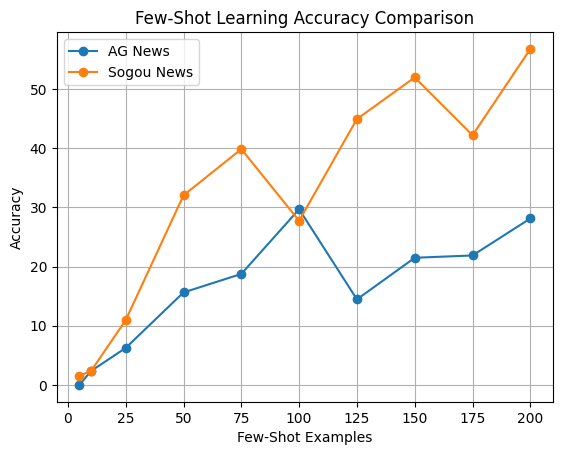

In [23]:
import matplotlib.pyplot as plt

# Plotting the line graphs
few_shot_examples = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]

plt.plot(few_shot_examples, few_shot_acc_ag, label='AG News', marker='o', linestyle='-')
plt.plot(few_shot_examples, few_shot_acc, label='Sogou News', marker='o', linestyle='-')

# Adding labels and legend
plt.title('Few-Shot Learning Accuracy Comparison - LSTM')
plt.xlabel('Few-Shot Examples')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [ ]:
few_shot_ag_lz4 = [0.6199444444444444, 0.6433333333333334, 0.6972222222222223, 0.735, 0.7558888888888889,
 0.7736111111111111, 0.7872222222222223, 0.7955555555555556, 0.8052777777777779, 0.8094444444444444]
few_shot_sogou_gzip = [0.6494666666666666, 0.6975555555555556, 0.7830666666666667, 0.8172, 0.8493333333333334,
 0.8548, 0.8646666666666667, 0.8710666666666667, 0.8758666666666667, 0.8785333333333334]


few_shot_ag_bert = [0.6199444444444444, 0.6433333333333334, 0.6972222222222223, 0.735, 0.7558888888888889,
 0.7736111111111111, 0.7872222222222223, 0.7955555555555556, 0.8052777777777779, 0.8094444444444444]
few_shot_sogou_bert = [0.6494666666666666, 0.6975555555555556, 0.7830666666666667, 0.8172, 0.8493333333333334,
 0.8548, 0.8646666666666667, 0.8710666666666667, 0.8758666666666667, 0.8785333333333334]

# lstm - ag
few_shot_acc_ag = [26.080729166666668,
 23.6328125,
 27.200520833333336,
 25.026041666666664,
 29.075520833333336,
 25.755208333333336,
 27.252604166666668,
 26.692708333333332,
 27.291666666666664,
 29.114583333333332]

# lstm - sogou
few_shot_acc = [29.156116737739872,
 22.799506929637527,
 33.34055170575693,
 38.43283582089552,
 39.74546908315565,
 57.19616204690831,
 57.93077025586354,
 53.14998667377399,
 67.31909648187633,
 59.384994669509595]

In [ ]:
import matplotlib.pyplot as plt

# Plotting the line graphs
few_shot_examples = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]

plt.plot(few_shot_examples, few_shot_acc_ag, label='AG News', marker='o', linestyle='-')
plt.plot(few_shot_examples, few_shot_acc, label='Sogou News', marker='o', linestyle='-')

# Adding labels and legend
plt.title('Few-Shot Learning Accuracy Comparison - LSTM')
plt.xlabel('Few-Shot Examples')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

few_shot_examples = [5, 10, 25, 50, 75, 100, 125, 150, 175, 200]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(few_shot_examples, few_shot_acc_ag, label='LSTM', marker='o', linestyle='-')
plt.plot(few_shot_examples, few_shot_acc_ag, label='BERT', marker='o', linestyle='-')
plt.plot(few_shot_examples, few_shot_ag_lz4, label='lz4', marker='o', linestyle='-')
plt.title('AG News')
plt.xlabel('Number of Shots')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(range(len(acc_val)), acc_val, label='Validation Accuracy')
plt.title('Sogou News')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.xticks(range(0,20,1),range(1,21,1))
best_epoch = acc_val.index(max(acc_val))
best_accuracy = max(acc_val)
plt.axvline(x=best_epoch, color='red', linestyle='--', label='Best Epoch')
plt.scatter(best_epoch, best_accuracy, color='red', s=100, label=f'Highest Accuracy: {best_accuracy:.2f}')


plt.tight_layout()

plt.show()